In [1]:
import torch
from time import time
from torch import nn, optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

### Helper methods

In [3]:
def fit_model(model, optimizer, criterion, train_data, val_data, num_epochs, batch_len, dev,
              scheduler = None, silent = False):
    print('======= FITTING MODEL ===========')
    print(model)
    print(optimizer)
    print(criterion)
    print('Batch size: ', batch_len)

    train_loader = DataLoader(train_data, batch_size = batch_len, shuffle = True)
    val_loader = DataLoader(val_data, batch_size = len(val_data))

    hist = { "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [] }

    print('Train on {} samples, validate on {} samples:'.format(
        len(train_data),
        len(val_data)
    ))

    start_time = time()

    for e in range(num_epochs):
        epoch_train_acc = epoch_train_loss = 0

        model.train()
        for train_images, train_labels in train_loader:
            train_images = train_images.reshape(-1, 28*28).to(dev)
            train_labels = train_labels.to(dev)

            optimizer.zero_grad()
            output = model(train_images)

            cost = criterion(output, train_labels)
            cost.backward()
            optimizer.step()

            ps = torch.exp(output)
            pred_prob, pred_label  = ps.topk(1, dim=1)
            true_label = train_labels.view(*pred_label.shape)
            equals = true_label == pred_label

            epoch_train_acc += torch.mean(equals.type(torch.FloatTensor)).item() / len(train_loader)
            epoch_train_loss += cost.item() / len(train_loader)

        model.eval()
        with torch.no_grad():
            val_images, val_labels = next(iter(val_loader))
            val_images = val_images.reshape(-1, 28*28).to(dev)
            val_labels = val_labels.to(dev)

            logps = model(val_images)
            cost = criterion(logps, val_labels)
            ps = torch.exp(logps)
            pred_prob, pred_label  = ps.topk(1, dim=1)
            true_label = val_labels.view(*pred_label.shape)
            equals = true_label == pred_label

            epoch_val_acc = torch.mean(equals.type(torch.FloatTensor)).item()
            epoch_val_loss = cost.item()

        if scheduler:
            scheduler.step()

        # Hold acuracy and loss scores for current epoch
        hist['train_acc'].append(epoch_train_acc)
        hist['train_loss'].append(epoch_train_loss)
        hist['val_acc'].append(epoch_val_acc)
        hist['val_loss'].append(epoch_val_loss)
        if not silent:
            print('Epoch {}/{}: Train Accuracy: {:.4f} - Train Loss: {:.4f} | Val. Accuracy: {:.4f} - Val. Loss: {:.4f}'.format(
                e+1,
                num_epochs,
                epoch_train_acc,
                epoch_train_loss,
                epoch_val_acc,
                epoch_val_loss
            ))
        else:
            print('.', end='')

    training_time = time() - start_time
    print('\nModel fit in : {:.2f}s'.format(training_time))

    return model, hist

def test_model(model, test_data, dev):
    val_loader = DataLoader(test_data, batch_size = len(test_data))
    model.eval()
    with torch.no_grad():
        val_images, val_labels = next(iter(val_loader))
        val_images = val_images.reshape(-1, 28*28).to(dev)
        val_labels = val_labels.to(dev)

        logps = model(val_images)
        ps = torch.exp(logps)
        pred_prob, pred_label  = ps.topk(1, dim=1)
        true_label = val_labels.view(*pred_label.shape)
        equals = true_label == pred_label

        accuracy = torch.mean(equals.type(torch.FloatTensor)).item()

    print('Test on {} samples - Accuracy: {:.4f}'.format(len(test_data), accuracy))

def init_weights_normal(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, std=.01, mean=.0)

def init_weights_xavier(layer):
    if type(layer) == nn.Linear:
        torch.nn.init.xavier_normal_(layer.weight)

def init_weights_zeros(layer):
    if type(layer) == nn.Linear:
        torch.nn.init.zeros_(layer.weight)

def plot_results(e, h, info):

    epochs_range = [i for i in range(e)]

    fig, (loss_plot, acc_plot) = plt.subplots(1, 2, figsize =(12,4))

    loss_plot.plot(epochs_range, h['train_loss'], color='red', label='train loss')
    loss_plot.plot(epochs_range, h['val_loss'], color='green', label='val loss')
    loss_plot.set_title('Epochs - Loss / {}'.format(info))
    loss_plot.legend()

    acc_plot.plot(epochs_range, h['train_acc'], color='red', label='train acc')
    acc_plot.plot(epochs_range, h['val_acc'], color='green', label='val acc')
    acc_plot.set_title('Epochs - Accuracy / {}'.format(info))
    acc_plot.legend()

    plt.show()

### 1) Import data

In [4]:
train_dataset = torchvision.datasets.MNIST(root='../../data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,[50000, 10000])

test_dataset = torchvision.datasets.MNIST(root='../../data',
                                          train=False,
                                          transform=transforms.ToTensor())

### 2) Softmax Classifier

======= FITTING MODEL ===========
Sequential(
  (0): Linear(in_features=784, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): LogSoftmax()
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
NLLLoss()
Batch size:  64
Train on 50000 samples, validate on 10000 samples:
Epoch 1/10: Train Accuracy: 0.8434 - Train Loss: 0.5066 | Val. Accuracy: 0.8984 - Val. Loss: 0.3373
Epoch 2/10: Train Accuracy: 0.9002 - Train Loss: 0.3467 | Val. Accuracy: 0.9018 - Val. Loss: 0.3544
Epoch 3/10: Train Accuracy: 0.9074 - Train Loss: 0.3203 | Val. Accuracy: 0.9095 - Val. Loss: 0.3230
Epoch 4/10: Train Accuracy: 0.9068 - Train Loss: 0.3228 | Val. Accuracy: 0.9182 - Val. Loss: 0.2931
Epoch 5/10: Train Accuracy: 0.9099 - Train Loss: 0.3093 | Val. Accuracy: 0.9122 - Val. Loss: 0.2962
Epoch 6/10: Train Accuracy: 0.9119 - Train Loss: 0.3013 | Val. Accuracy: 0.9026 - Val. Loss: 0.3227
Epoch 7/10:

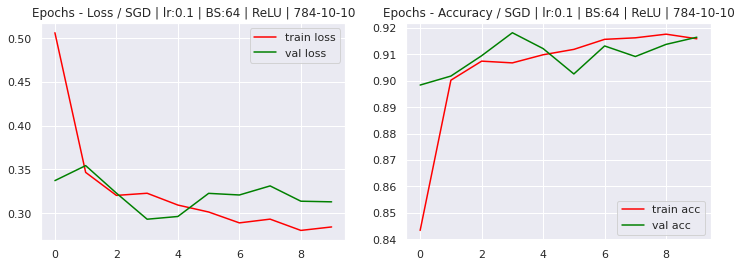

In [5]:
epochs = 10
batch_size = 64

network = nn.Sequential(
    nn.Linear(784, 10),
    nn.ReLU(),
    nn.Linear(10, 10),
    nn.LogSoftmax(dim=1)
).to(device)

network.apply(init_weights_normal)

optim_func = optim.SGD(network.parameters(), lr=0.1, momentum=0.9)
loss_func = nn.NLLLoss()

network, history = fit_model(
    model = network,
    optimizer = optim_func,
    criterion = loss_func,
    train_data = train_dataset,
    val_data = val_dataset,
    num_epochs = epochs,
    batch_len = batch_size,
    dev = device)

test_model(
    model = network,
    test_data= test_dataset,
    dev = device)

plot_results(epochs, history, info='SGD | lr:0.1 | BS:64 | ReLU | 784-10-10')

### 3) Model after hyperparameter calibration

======= FITTING MODEL ===========
Sequential(
  (0): Linear(in_features=784, out_features=1280, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): LeakyReLU(negative_slope=0.01)
  (3): Linear(in_features=1280, out_features=1280, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=1280, out_features=1280, bias=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=1280, out_features=10, bias=True)
  (10): LogSoftmax()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.0015
    lr: 0.0015
    weight_decay: 0
)
NLLLoss()
Batch size:  256
Train on 50000 samples, validate on 10000 samples:
Epoch 1/12: Train Accuracy: 0.9189 - Train Loss: 0.2589 | Val. Accuracy: 0.9654 - Val. Loss: 0.1068
Epoch 2/12: Train Accuracy: 0.9684 - Train Loss: 0.1013 | Val. Accuracy: 0.9712 - Val. Loss: 0.0975
Epoch 3/12: Train Accuracy: 0.9760 - Tra

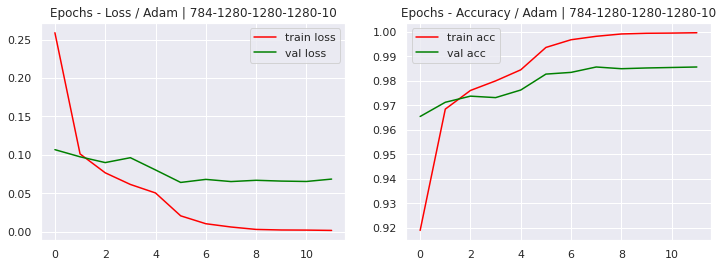

In [6]:
epochs = 12
batch_size = 256
# learning_rate = 0.3
learning_rate = .0015
learning_rate_decay = 0.43


input_layer = nn.Linear(784, 1280)
nn.init.kaiming_normal_(input_layer.weight)

hidden1_layer = nn.Linear(1280, 1280)
nn.init.kaiming_normal_(hidden1_layer.weight)

hidden2_layer = nn.Linear(1280, 1280)
nn.init.kaiming_normal_(hidden2_layer.weight)

output_layer = nn.Linear(1280, 10)
nn.init.normal_(output_layer.weight, std=0.01)

network = nn.Sequential(

    input_layer,
    nn.Dropout(0.2),
    nn.LeakyReLU(),

    hidden1_layer,
    nn.Dropout(0.2),
    nn.LeakyReLU(),

    hidden2_layer,
    nn.Dropout(0.1),
    nn.LeakyReLU(),

    output_layer,
    nn.LogSoftmax(dim=1)
    ).to(device)

loss_func = nn.NLLLoss()
optim_func = optim.Adam(network.parameters(), lr=learning_rate,)
# optim_func = optim.SGD(network.parameters(), lr=learning_rate, momentum=0.9)
sched_func = optim.lr_scheduler.MultiStepLR(optim_func, milestones=[5,7,9], gamma=learning_rate_decay)

network, history = fit_model(
    model = network,
    optimizer = optim_func,
    criterion = loss_func,
    train_data = train_dataset,
    val_data = val_dataset,
    num_epochs = epochs,
    batch_len = batch_size,
    dev = device,
    scheduler = sched_func
)

test_model(
    model = network,
    test_data= test_dataset,
    dev = device)

plot_results(epochs, history, info='Adam | 784-1280-1280-1280-10')


### Findings

Trials using different optimizers, learning rates, learning rate decays, batch sizes, network architectures, activation functions and weight initializations were executed. Dropout were also tested. For every hyperparameter checked, the rest of the hyperparameter settings were kept as in the 2nd question  in order to better identify differences.

#### Learning Rate & Batch Size
Using SGD, tiny learning rates (1-e5, 1-e4,..) result in too slow learning curve while starting from a decent point in performance. On the other hand, large ones (1, 5,..) drive performance through the floor. Regarding batch size, large size (above 1024) usually results in flat horizontal lines for both accuracy and loss. Sizes below 512 are ideal, depending also to the learning rate.

#### Weight initialization
Normal, xavier_normal, kaiming_normal and zeros weight initializations were used. For the normal std=0.01 and mean=0.0 were used. No significant difference was observed between normal and xavier initializations. Kaiming initialization has shown better results, given also the fact that leaky ReLU seemed to produce better results than others and thus, was used as the activation function.

#### Activation functions
ReLU, leaky ReLU, sigmoid, tanh, softmax and softplus functions were tested in the hidden layers. Leaky ReLU seems to produce better results but, all functions produced validation accuracies above 0.9, except for the softmax. For the output layer, softmax was preserved as the activation function. 

#### Network architecture
Architectures with up to three hidden layers were tested, with layers sizing from 16 to 2048 nodes. Again the hyperparameter settings from the 2nd question were used. Two architectures stand out for their performance: the 784-512-10 and the 784-256-256-10.

#### Optimizer functions
Optimizer functions perform better using different learning rate ranges each. After many trials Adagrad and SGD performed the best with analogous adjustments, both reaching between 0.980-0.983 test accuracy. Adam was also tested extensively reaching 0.97-0.98 test accuracy. Adadelta, Adamax and RMSProp optimizers were also tested. Each optimizer was tested with learning rates ranging in [0.1, .. 0.001]

#### Dropout
As method it is used to cut out some nodes during the training phase in order to help minimize the overfit of the model. The use of dropout layers resulted in poorer performance and were not dimmed necessary for this problem, given also the fact that the accuracy/loss plots during training/validation phase proved that there is no overfit problem for a span of 10 epochs.

#### Other notes
Increasing the number of epochs was also tested. For the final model, the ideal number of epochs seems to be 12.
LeakyReLU was selected along with Kaiming weights initialization due to related paper. Initially, SGD was selected,
then learning rate deacay was applied (trials resulted in the related steps) then, Adam optimizer was selected using
the same learning rate decay as SGD (it seems that Adam is affected by the learning rate decay, despite the fact that
 it adapts the learning rate internally). Dropout layers were used to avoid overfitting. Trials were made also using 
 TF-Keras but, pytorch was selected to delve in the specifics of training a neural net. Due to the fact that pytorch was used. 
 K-fold cross validation was not implemented because it would require much more code and time, in my opinion, out of the scope of
 the assignment. However, after many trials, accuracy seems to reach values above .985 consistently
